In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [195]:
# Plotting adjustments
plt.rcParams["font.family"] = "Times New Roman"
sns.set_theme(style="whitegrid", font="Times New Roman")
plt.rcParams['savefig.dpi'] = 300
plt.rcParams.update({'figure.autolayout': True})

In [196]:
# Import excel files
classification = pd.read_excel('results.xlsx', sheet_name = 'Classification')
regression = pd.read_excel('results.xlsx', sheet_name = 'Regression')

In [197]:
# Group the data by summarisation method and task
grouped = classification.groupby(['Summarisation Method', 'Task', 'Model type'])

# Define a function to calculate the weighted average
weighted_avg = lambda x: np.average(x, weights=classification.loc[x.index, 'Support'])

# Initialize a new dataframe to store the results
classification_results = pd.DataFrame(columns=['Summarisation Method', 'Task', 'Macro F1-score', 'Micro F1-score', 'Weighted F1-score'])

# Calculate the macro, micro, and weighted averages for each group and store the results in the new dataframe
for name, group in grouped:
    precision = group['Precision']
    recall = group['Recall']
    f1 = group['F1-score']
    support = group['Support']
    
    # Calculate macro average
    precision_macro = np.mean(precision)
    recall_macro = np.mean(recall)
    f1_macro = np.mean(f1)
    
    # Calculate micro average
    TP = sum(support * f1)
    FP = sum(support * (1 - precision))
    FN = sum(support * (1 - recall))
    precision_micro = TP / (TP + FP)
    recall_micro = TP / (TP + FN)
    f1_micro = 2 * precision_micro * recall_micro / (precision_micro + recall_micro)
    
    # Calculate weighted average
    precision_weighted = weighted_avg(precision)
    recall_weighted = weighted_avg(recall)
    f1_weighted = weighted_avg(f1)
    
    # Store the results in the new dataframe
    temp_df = pd.DataFrame({'Summarisation Method': name[0],
                            'Task': name[1],
                            'Model type': name[2],
                            'Macro F1-score': f1_macro,
                            'Micro F1-score': f1_micro,
                            'Weighted F1-score': f1_weighted},
                            index=[0])
    classification_results = pd.concat([classification_results, temp_df], ignore_index=True)

# Sort alphabetically by model type and summarisation method and them task
classification_results.sort_values(by=['Model type', 'Summarisation Method', 'Task'], inplace=True)

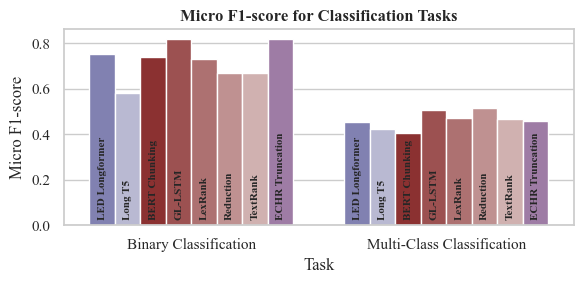

In [198]:
# Define the color palette for the plot
palette = {
    "Abstractive": sns.light_palette("navy", n_colors=5, reverse=True),
    "Extractive": sns.light_palette("darkred", n_colors=8, reverse=True),
    "No summarisation": sns.light_palette("#a275ac", n_colors=4, reverse=True),
}


# Create a custom color mapping for the Summarisation Methods
custom_mapping = {
    "LED Longformer": palette["Abstractive"][2],
    "Long T5": palette["Abstractive"][3],
    "BERT Chunking": palette["Extractive"][1],
    "GL-LSTM": palette["Extractive"][2],
    "LexRank": palette["Extractive"][3],
    "Reduction": palette["Extractive"][4],
    "TextRank": palette["Extractive"][5],
    "ECHR Truncation": palette["No summarisation"][0]
}

# Map the colors to the Summarisation Method
classification_results['Color'] = classification_results['Summarisation Method'].map(custom_mapping)

# Use seaborn to create the bar plot
fig = plt.figure(figsize=(6, 3))
ax = sns.barplot(x="Task", y="Micro F1-score", hue="Summarisation Method", data=classification_results, palette=classification_results['Color'][classification_results['Task'] == 'Binary Classification'])
ax.set_title("Micro F1-score for Classification Tasks", fontsize=12, weight="bold")
#ax.legend(title="Summarisation Method", loc="upper right", ncols=2)
ax.legend_.remove()

# Add Summarisation Method on top of each bar rotated 90 degrees with aligned starting point
for p, label in zip(ax.patches, classification_results['Summarisation Method']):
    ax.annotate(label, (p.get_x() + p.get_width() / 2., 0.025),
                ha='center', va='bottom', rotation=90, weight = "bold", fontsize = 8,
                xytext=(0, 0), textcoords='offset points')

fig.tight_layout()
fig.savefig('plots/classification_results.png', dpi=300, bbox_inches='tight')

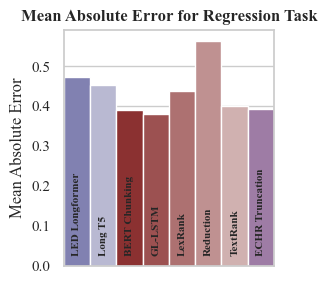

In [215]:
regression.sort_values(by=['Model type', 'Summarisation Method'], inplace=True)
regression['Color'] = regression['Summarisation Method'].map(custom_mapping)
regression['x_axis'] = np.arange(len(regression))


# Use seaborn to create the bar plot
fig = plt.figure(figsize=(3, 3))
ax = sns.barplot(x = 'x_axis', y="Mean Absolute Error", data=regression, palette=regression['Color'], width=1)
ax.set_title("Mean Absolute Error for Regression Task", fontsize=12, weight="bold")
ax.set(xlabel=None)
ax.set(xticklabels=[])

#Add Summarisation Method on top of each bar rotated 90 degrees with aligned starting point
for p, label in zip(ax.patches, regression['Summarisation Method']):
    ax.annotate(label, (p.get_x() + p.get_width() / 2., 0.025),
                ha='center', va='bottom', rotation=90, weight = "bold", fontsize = 8,
                xytext=(0, 0), textcoords='offset points')

fig.tight_layout()
fig.savefig('plots/regression_results.png', dpi=300, bbox_inches='tight')